# Frank's Indepth Tutorial of the Reweighing Technique
##### Author: Guanzhong Chen
##### Date: 04/17/2020
*Reference: F. Kamiran and T. Calders,  "Data Preprocessing Techniques for Classification without Discrimination," Knowledge and Information Systems, 2012.*

## 1. Introduction to Bias in Machine Learning

This tutorial is meant to introduce one of the techniques in AI Fairness 360 (AIF360) package called "Reweighing Technique." The AIF360 toolkit is an open-source library the helps machine learning researchers and the whole community detect and mitigate bias in machine learning models.

To give a brief background introduction of bias in machine learning, we look at a very simple dataset. This dataset classifies people described by a set of attributes as good or bad credit risks. File used is `german.data` consisting of 1000 instances and 20 features. In this case we focus on the supervised machine learning problem with a binary target of the credit risks being either "good" or "bad." A machine learning model will learn and generalize the pattern from a training dataset and make predictions on a test dataset based on what it has learned. However, here is a problem. The training dataset may not be representative of the true population of people of all age groups. For example, in the training dataset, people with ages more than 25 are much more likely to receive a good credit risk due to the source of the dataset or some other reasons. However, the true distribution might be otherwise. This will generate bias and be unfavorable for people with ages less than 25. In this case, "age" will be our protected attribute, and it separates the instances into two groups: more than 25 and less than 25.

Before further investigation, let's first import the german dataset, set the protected attribute, set the threshold of separation, set the training and testing dataset, and drop other sensitive attributes.

In [1]:
# Load all necessary packages
import sys
sys.path.insert(1, "../")  

import numpy as np
np.random.seed(0)

from aif360.datasets import GermanDataset
from aif360.metrics import BinaryLabelDatasetMetric
from aif360.algorithms.preprocessing import Reweighing

from IPython.display import Markdown, display

Matplotlib Error, comment out matplotlib.use('TkAgg')


In [2]:
dataset_orig = GermanDataset(
    protected_attribute_names=['age'],           
    privileged_classes=[lambda x: x >= 25],      
    features_to_drop=['personal_status', 'sex'] 
)

dataset_orig_train, dataset_orig_test = dataset_orig.split([0.7], shuffle=True)

privileged_groups = [{'age': 1}]
unprivileged_groups = [{'age': 0}]

## 2. Preprocessing Techniques to Mitigate Bias

There are many solutions to mitigate bias in machine learning. In this tutorial, we focus on those that are proceeded before training. They are known as the "preprocessing" techniques.

We list three of them here that are commonly used. We give a brief introduction to what they are and what their pros and cons are to help readers to choose the one that is most suitable for them.

1. **Suppresion**: First, we identify the attributes that are most correlated with the protected attribute $A$. Then, we just remove $A$ and these most correlated attribute. 
    * **Pros**: the algorithm itself is straightforward to understand and easy to implement. 
    * **Cons**: Sometimes we can't get rid of the protected attributes easily by just removing them. Some of them may be critical for companies' bussiness analysis, and some of them may be important for the classification process.

2. **Dataset Massaging**: We change the labels of some objects in the dataset. Selections of the labels to change will base on a ranker that is related to Naive Bayes classifier.
    * **Pros**: It help mitigate bias even if the protected attributes are not allowed to be removed. It is also relatively easy to understand.
    * **Cons**: It is, in a sense, rather intrusive as it changes the labels of the instances.

2. **Reweighing**: We give training instances weights according to the law of statistical independence.
    * **Pros**: It is calculation-friendly. We can implement this algorithm using frequency count. Compared to dataset massaging, it also helps mitigate bias without changing the labels.
    * **Cons**: More difficult to implement compared to the two techniques mentioned above.

## 3. Elaboration on Reweighing

#### a. Notations and Weight Concept

To have an idea of how this technique works, we first introduce some notations. We assume the protected attribute and the target variable are binary. Specifically, we denote the protected attribute as $A$ with two values $\{b,w\}$. We denote the target class as $T$ with two values $\{+, -\}$. The classifier we use is denoted as $C$, and the random unlabeled data subject is denoted as $X$. Also the training dataset is denoted as $D$.

If the dataset $D$ is unbiased, $A$ and $T$ are statistically independent. This means that the expected probability to see an instance with its protected attribute value and class given independence can be calculated as the following:  

$$
P_{exp}(A=b \wedge T=+) = \frac{|\{X \in D | X(A) = b\}|}{|D|} * \frac{|\{X \in D | X(T) = +\}|}{|D|}
$$

In reality, the observed probability to see an instance with its protected attribute value and class is calculated as the following:  

$$
P_{obs}(A=b \wedge T=+) = \frac{|\{X \in D | X(A) = b \wedge X(T) = +\}|}{|D|}
$$

We notice that $P_{exp}$ and $P_{obs}$ are usually different. We assign the weight for each instance to be $W$ that is calculated as the following:

$$
W(X) = \frac{P_{exp}(A=b \wedge T=+)}{P_{obs}(A=b \wedge T=+)}
$$

We notice that $W(X)$ is essentially the expected probability divided by the observed probability. In this way, we assign lower weights to objects that have been deprived or favored to compensate for the bias.

#### b. A Concrete Example of Weight Calculation

Notations may be abstract for some readers. We therefore look at a concrete example using the same dataset mentioned above.

We recall that our protected attribute here is the "age." And this protected attribute is already binary (1.0 vs 0.0) by setting the threshold 25. If an person is older than or is 25 years old, we label him/her as 1.0 in the age attribute. We label him/her 0.0 otherwise. We also have binary value for the target class. In this case 1.0 means good credit risk, and 2.0 means bad credit risk. 

First we want to calculate the expected probability to see an instance with its protected attribute value and class given independence. Specifically, we look at $P_{exp}(A=1.0 \wedge T=1.0)$ first.

As the equation indicates above, we need to calculate the frequency count of $A = 1.0$ in the training set first. That is $|\{X \in D | X(A) = 1.0\}|$.

In [3]:
freq_count_of_age_bigger_25 = sum(dataset_orig_train.convert_to_dataframe()[0]["age"] == 1.0)
freq_count_of_age_bigger_25

587

In other words, in this dataset, **we have a total of 587 people who are older than or are at age 25**.

And the frequency count of T = 1.0 next. That is $|\{X \in D | X(T) = 1.0\}|$.

In [4]:
freq_count_of_good_credit = sum(dataset_orig_train.convert_to_dataframe()[0]["credit"] == 1.0)
freq_count_of_good_credit

490

In other words, in this dataset, **we have a total of 490 people who have a good credit risk**.

Finally, we need to know the total number of training instance. That is $|D|$.

In [5]:
total_instance = len(dataset_orig_train.convert_to_dataframe()[0]["credit"])
total_instance

700

Combine the three values above, we have:

$$
P_{exp}(A=1.0 \wedge T=1.0) = \frac{|\{X \in D | X(A) = 1.0\}|}{|D|} * \frac{|\{X \in D | X(T) = 1.0\}|}{|D|}
$$

We can calculate this value in Python.

In [6]:
P_exp = freq_count_of_age_bigger_25/total_instance * freq_count_of_good_credit/total_instance
P_exp

0.587

Next we calculate the observed probability $P_{obs}(A=1.0 \wedge T=1.0)$.

As the equation indicates above, we need to calculate the frequency count of $A = 1.0$ and $T = 1.0$ in the training set first. That is $|\{X \in D | X(A) = 1.0 \wedge X(T) = 1.0\}|$.

In [8]:
df = dataset_orig_train.convert_to_dataframe()[0]
freq_count_both = df[(df['age']==1.0)&(df['credit']==1.0)].shape[0]
freq_count_both

427

In other words, in this dataset, **we have a total of 427 people who have a good credit risk and older than or are at age 25**.

Since we already the total number of training instance is 700. We can calcuate the $P_{obs}$ easily using the following equation.

$$
P_{obs}(A=1.0 \wedge T=1.0) = \frac{|\{X \in D | X(A) = 1.0 \wedge X(T) = 1.0\}|}{|D|}
$$

We can calculate this specific value in Python.

In [9]:
P_obs = freq_count_both / total_instance
P_obs

0.61

Finally, we can calculate the weight using the two probabilities.

$$
W(X) = \frac{P_{exp}(A=1.0 \wedge T=1.0)}{P_{obs}(A=1.0 \wedge T=1.0)}
$$

Again, the mathematical value can be calculated in Python.

In [11]:
weight = P_exp / P_obs
weight

0.962295081967213

That is the weight we will assign to for each instance with $A = 1.0$ and $T = 1.0$ in the training set.

**Summary: this means that for this dataset, we give people who are older than or at age 25 AND have a good credit risk a weight of 0.587.**

Thanks to the AIF360 package, we do not have to go through this weight-assigning preprocessing by hand ourselves. The package has its own function that calculates the weights for us automatically. 

In [12]:
RW = Reweighing(unprivileged_groups=unprivileged_groups,
                privileged_groups=privileged_groups)
dataset_transf_train = RW.fit_transform(dataset_orig_train)

We can confirm if our calculation is correct using the package.

In [13]:
print(RW.w_p_fav) # S is 1.0 and T is 1.0

0.9622950819672131


Congragulations! We have achieved the same result.

The other thing to notice is that since $A$ and $T$ are both binary, we have a total of 4 different weights to assign. If reader is interested, he/she can calculate the other 3 values of weight by hand and confirm them with AIF360.

In [14]:
print(RW.w_p_unfav)
print(RW.w_up_fav)
print(RW.w_up_unfav)

1.100625
1.2555555555555555
0.678


**Summary:**  
**1. First value says that for this dataset, we give people who are younger than age 25 AND have a good credit risk a weight of 1.100625.**  
**2. Second value says that for this dataset, we give people who are older than or at age 25 AND have a bad credit risk a weight of 1.2555555555555555.**  
**3. Third value says that for this dataset, we give people who younger than age 25 AND have a bad credit risk a weight of 0.678.**

We can further visualize how many instances receive a specific weight value using a bar plot in Python.

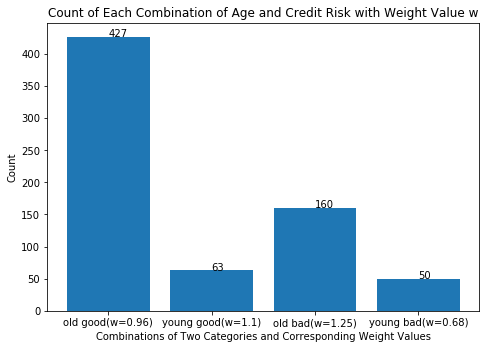

In [39]:
old_good = df[(df['age']==1.0)&(df['credit']==1.0)].shape[0]
young_good = df[(df['age']==0.0)&(df['credit']==1.0)].shape[0]
old_bad = df[(df['age']==1.0)&(df['credit']==2.0)].shape[0]
young_bad = df[(df['age']==0.0)&(df['credit']==2.0)].shape[0]

import matplotlib.pyplot as plt
fig = plt.figure()
ax = fig.add_axes([0,0,1,1])
langs = ['old good(w=0.96)', 'young good(w=1.1)', 'old bad(w=1.25)', 'young bad(w=0.68)']
counts = [old_good,young_good,old_bad,young_bad]
ax.bar(langs,counts)
for i, v in enumerate(counts):
    plt.text(langs[i],v, str(v))
plt.title("Count of Each Combination of Age and Credit Risk with Weight Value w")
plt.xlabel('Combinations of Two Categories and Corresponding Weight Values')
plt.ylabel('Count')
plt.show()

## 4. Results with Reweighing

After understanding how Reweighing works, we want to see if this preprocessing technique really works. We will use a metric called "BinaryLabelDatasetMetric."

We first apply this metric to the original training dataset.

In [40]:
metric_orig_train = BinaryLabelDatasetMetric(dataset_orig_train, 
                                             unprivileged_groups=unprivileged_groups,
                                             privileged_groups=privileged_groups)
display(Markdown("#### Original training dataset"))
print("Difference in mean outcomes between unprivileged and privileged groups = %f" % metric_orig_train.mean_difference())

#### Original training dataset

Difference in mean outcomes between unprivileged and privileged groups = -0.169905


As we can see, the result showed that the privileged group was getting 17% more positive outcomes in the training dataset. Therefore the dataset is biased. We may want to mitigate this bias using the Reweighing preprocessing technique and see what happen to the metric after all.

In [41]:
metric_transf_train = BinaryLabelDatasetMetric(dataset_transf_train, 
                                               unprivileged_groups=unprivileged_groups,
                                               privileged_groups=privileged_groups)
display(Markdown("#### Transformed training dataset"))
print("Difference in mean outcomes between unprivileged and privileged groups = %f" % metric_transf_train.mean_difference())

#### Transformed training dataset

Difference in mean outcomes between unprivileged and privileged groups = 0.000000


As a result, after we apply the Reweighing, the bias is mitigated.